Dados originais: 224 linhas, 12 colunas
Colunas para análise: ['IDHM 2010 ', 'IDEB AI - Pública', 'IDEB Anos Finais - Pública', 'SAEPI Português 2º ano Ensino Fundamental ', 'SAEPI Matemática 2º ano Ensino Fundamental ', 'Taxa de evasão ensino fund. Anos Iniciais', 'Taxa de evasão ensino fund. Anos Finais ']
Dados após filtragem: 224 linhas
Variáveis de taxas: ['IDHM 2010 ', 'IDEB AI - Pública', 'IDEB Anos Finais - Pública', 'Taxa de evasão ensino fund. Anos Iniciais', 'Taxa de evasão ensino fund. Anos Finais ']
Variáveis absolutas: ['SAEPI Português 2º ano Ensino Fundamental ', 'SAEPI Matemática 2º ano Ensino Fundamental ']
Features: 7, Método: min_max, PCA: True, RS: 42, Silhouette: 0.2061, Min Size: 25.45%
Features: 7, Método: min_max, PCA: True, RS: 0, Silhouette: 0.2064, Min Size: 25.00%
Features: 7, Método: min_max, PCA: True, RS: 10, Silhouette: 0.2064, Min Size: 25.00%
Features: 7, Método: min_max, PCA: True, RS: 20, Silhouette: 0.2064, Min Size: 25.00%
Features: 7, Método: min

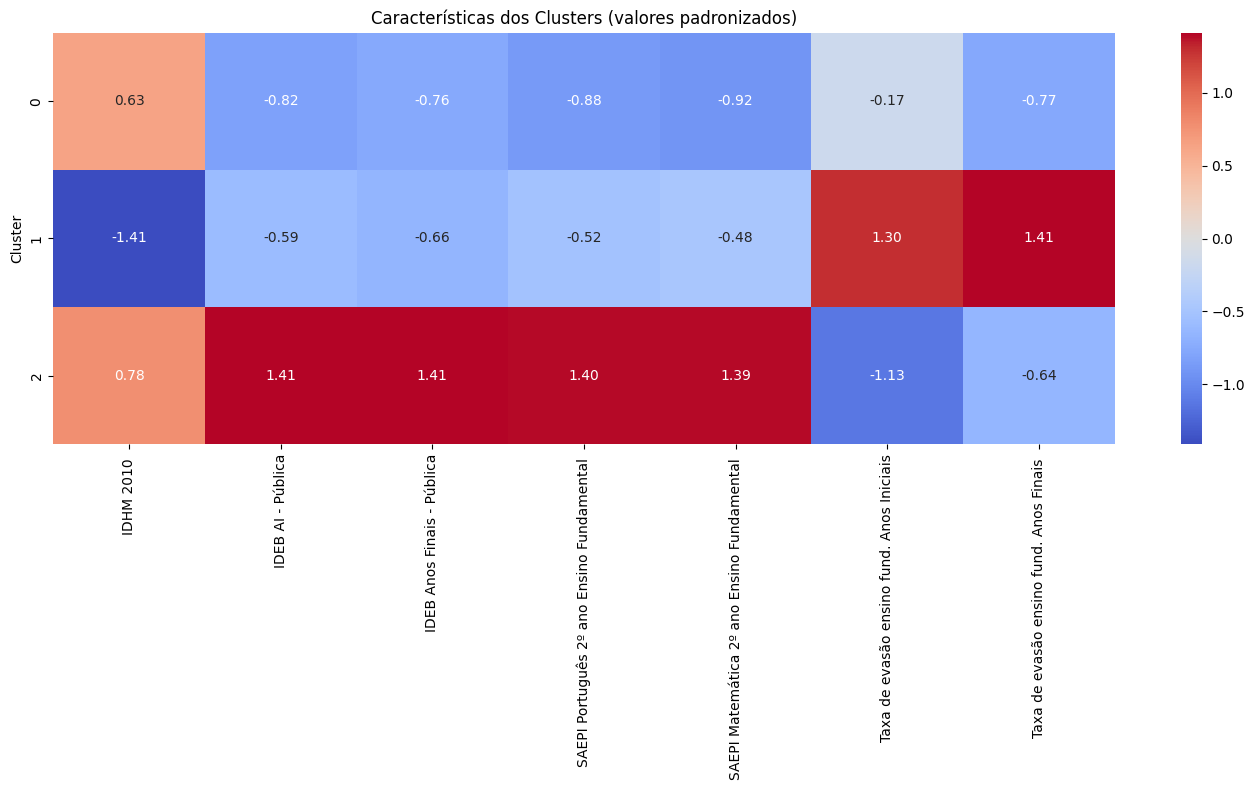

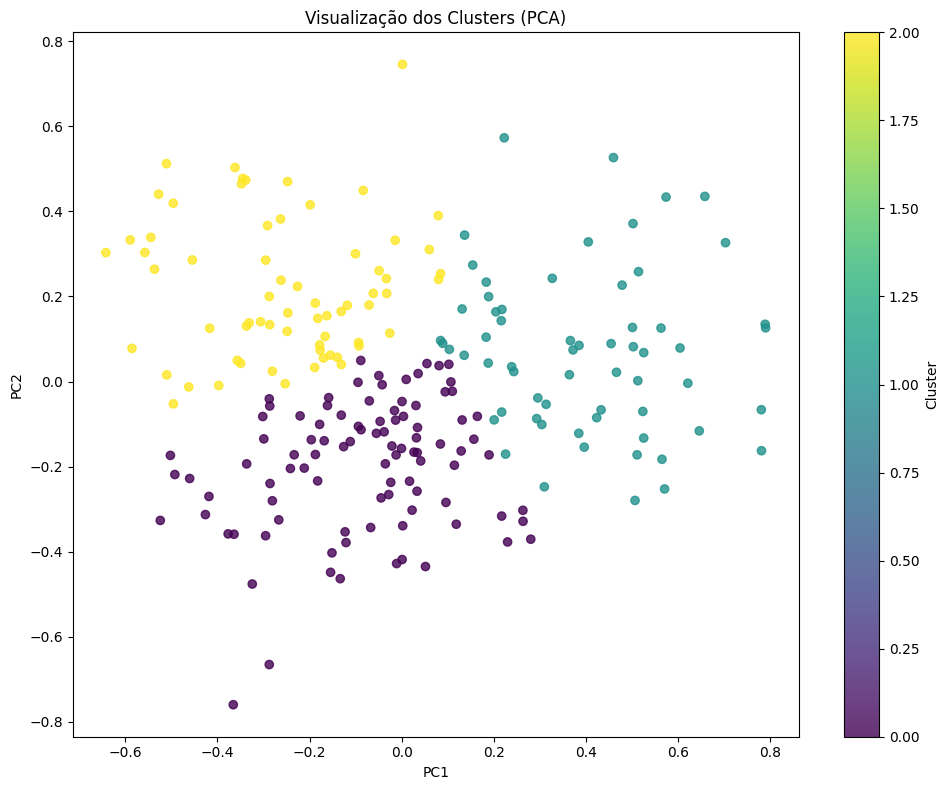

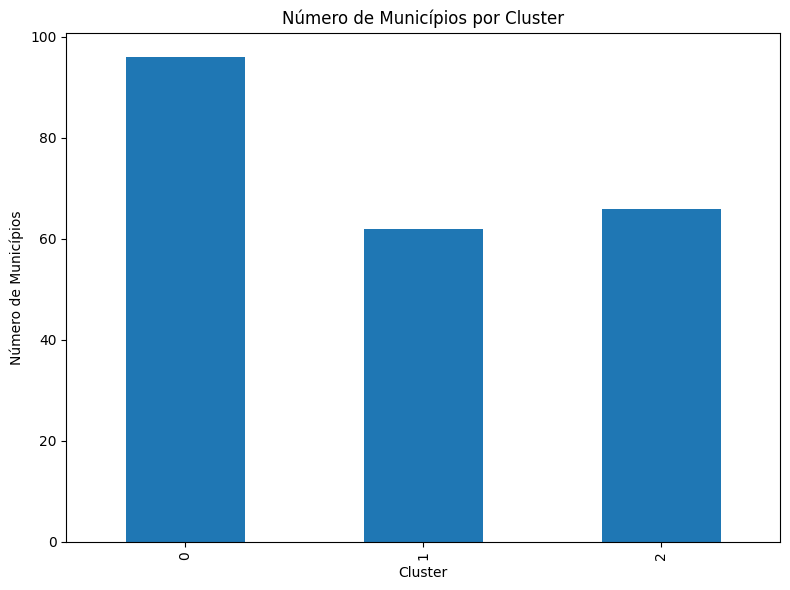

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Definindo PRIMEIRO todas as funções auxiliares
def calcular_importancia_variaveis(df, colunas):
    """Calcula a importância das variáveis para cada cluster"""
    importancia = pd.DataFrame(index=colunas)
    
    # Para cada cluster, calcular a diferença em relação à média geral (z-score)
    for cluster in df['Cluster'].unique():
        # Média do cluster
        media_cluster = df[df['Cluster'] == cluster][colunas].mean()
        # Média geral
        media_geral = df[colunas].mean()
        # Desvio padrão geral
        std_geral = df[colunas].std()
        
        # Calcular score Z para cada variável
        z_scores = (media_cluster - media_geral) / std_geral
        importancia[f'Cluster {cluster}'] = z_scores
    
    # Ordenar variáveis por importância total (soma dos valores absolutos)
    importancia['Importância Total'] = importancia.abs().sum(axis=1)
    importancia = importancia.sort_values('Importância Total', ascending=False)
    
    return importancia

def visualizar_resultados(df, colunas, X_final, usou_pca):
    """Visualiza os resultados da clusterização"""
    # 1. Mapa de calor das médias dos clusters
    plt.figure(figsize=(14, 8))
    cluster_means = df.groupby('Cluster')[colunas].mean()
    
    # Normalizar para comparação
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    cluster_means_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_means),
        index=cluster_means.index,
        columns=cluster_means.columns
    )
    
    sns.heatmap(cluster_means_scaled, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Características dos Clusters (valores padronizados)')
    plt.tight_layout()
    plt.savefig('cluster_characteristics.png')
    
    # 2. Visualização dos clusters (scatter plot)
    if usou_pca:
        plt.figure(figsize=(10, 8))
        plt.scatter(X_final[:, 0], X_final[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.8)
        plt.title('Visualização dos Clusters (PCA)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.colorbar(label='Cluster')
        plt.tight_layout()
        plt.savefig('cluster_visualization_pca.png')
    else:
        # Se não usou PCA, selecionar as duas variáveis mais importantes
        importancia = calcular_importancia_variaveis(df, colunas)
        top_vars = importancia.index[:2].tolist()
        
        plt.figure(figsize=(10, 8))
        plt.scatter(df[top_vars[0]], df[top_vars[1]], c=df['Cluster'], cmap='viridis', alpha=0.8)
        plt.title(f'Visualização dos Clusters ({top_vars[0]} vs {top_vars[1]})')
        plt.xlabel(top_vars[0])
        plt.ylabel(top_vars[1])
        plt.colorbar(label='Cluster')
        plt.tight_layout()
        plt.savefig('cluster_visualization_vars.png')
    
    # 3. Distribuição dos tamanhos dos clusters
    plt.figure(figsize=(8, 6))
    df['Cluster'].value_counts().sort_index().plot(kind='bar')
    plt.title('Número de Municípios por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Número de Municípios')
    plt.tight_layout()
    plt.savefig('cluster_sizes.png')

def sugerir_politicas(cluster, estatisticas, importancia):
    """
    Sugere políticas educacionais baseadas no perfil do cluster
    """
    cluster_col = f'Cluster {cluster}'
    
    # Analisar principais desafios
    evasao_ai_zscore = importancia.loc['Taxa de evasão ensino fund. Anos Iniciais', cluster_col] if 'Taxa de evasão ensino fund. Anos Iniciais' in importancia.index else 0
    evasao_af_zscore = importancia.loc['Taxa de evasão ensino fund. Anos Finais ', cluster_col] if 'Taxa de evasão ensino fund. Anos Finais ' in importancia.index else 0
    ideb_ai_zscore = importancia.loc['IDEB AI - Pública', cluster_col] if 'IDEB AI - Pública' in importancia.index else 0
    ideb_af_zscore = importancia.loc['IDEB Anos Finais - Pública', cluster_col] if 'IDEB Anos Finais - Pública' in importancia.index else 0
    saepi_port_zscore = importancia.loc['SAEPI Português 2º ano Ensino Fundamental ', cluster_col] if 'SAEPI Português 2º ano Ensino Fundamental ' in importancia.index else 0
    saepi_mat_zscore = importancia.loc['SAEPI Matemática 2º ano Ensino Fundamental ', cluster_col] if 'SAEPI Matemática 2º ano Ensino Fundamental ' in importancia.index else 0
    
    sugestoes = []
    
    # Sugestões para evasão
    if evasao_ai_zscore > 0.3 or evasao_af_zscore > 0.3:
        sugestoes.append("Programas de busca ativa e acompanhamento personalizado de alunos em risco de evasão")
        sugestoes.append("Fortalecimento da merenda escolar e transporte para garantir permanência dos estudantes")
    
    # Sugestões para IDEB
    if ideb_ai_zscore < -0.3:
        sugestoes.append("Investimento em formação continuada para professores dos anos iniciais")
        sugestoes.append("Implementação de programas de alfabetização e letramento na idade certa")
    
    if ideb_af_zscore < -0.3:
        sugestoes.append("Projetos pedagógicos interdisciplinares para anos finais")
        sugestoes.append("Mentoria e reforço escolar para estudantes com dificuldades")
    
    # Sugestões para SAEPI
    if saepi_port_zscore < -0.3:
        sugestoes.append("Fortalecimento de projetos de leitura e produção textual")
    
    if saepi_mat_zscore < -0.3:
        sugestoes.append("Implementação de metodologias ativas para o ensino de matemática")
    
    # Sugestões gerais para melhoria
    if saepi_port_zscore < 0 or saepi_mat_zscore < 0 or ideb_ai_zscore < 0 or ideb_af_zscore < 0:
        sugestoes.append("Análise periódica de indicadores educacionais para ajustes nas estratégias pedagógicas")
        sugestoes.append("Parcerias com universidades para programas de extensão e apoio às escolas")
    
    # Imprimir sugestões de políticas
    if sugestoes:
        print("\nSugestões de políticas educacionais:")
        for i, sugestao in enumerate(sugestoes[:3], 1):  # Limitar a 3 sugestões
            print(f"{i}. {sugestao}")
    else:
        print("\nSugestão: Manter as políticas educacionais atuais e compartilhar boas práticas com outros municípios.")

def interpret_cluster_performance(cluster, estatisticas, importancia):
    """
    Fornece uma interpretação do desempenho educacional do cluster
    """
    cluster_col = f'Cluster {cluster}'
    
    # Verificar desempenho em IDEB e SAEPI
    ideb_ai_zscore = importancia.loc['IDEB AI - Pública', cluster_col] if 'IDEB AI - Pública' in importancia.index else 0
    ideb_af_zscore = importancia.loc['IDEB Anos Finais - Pública', cluster_col] if 'IDEB Anos Finais - Pública' in importancia.index else 0
    saepi_port_zscore = importancia.loc['SAEPI Português 2º ano Ensino Fundamental ', cluster_col] if 'SAEPI Português 2º ano Ensino Fundamental ' in importancia.index else 0
    saepi_mat_zscore = importancia.loc['SAEPI Matemática 2º ano Ensino Fundamental ', cluster_col] if 'SAEPI Matemática 2º ano Ensino Fundamental ' in importancia.index else 0
    
    # Verificar taxas de evasão
    evasao_ai_zscore = importancia.loc['Taxa de evasão ensino fund. Anos Iniciais', cluster_col] if 'Taxa de evasão ensino fund. Anos Iniciais' in importancia.index else 0
    evasao_af_zscore = importancia.loc['Taxa de evasão ensino fund. Anos Finais ', cluster_col] if 'Taxa de evasão ensino fund. Anos Finais ' in importancia.index else 0
    
    # Calcular score geral de desempenho (media ponderada dos z-scores)
    desempenho_score = (
        1.0 * ideb_ai_zscore + 
        0.8 * ideb_af_zscore + 
        0.7 * saepi_port_zscore + 
        0.7 * saepi_mat_zscore - 
        0.6 * evasao_ai_zscore - 
        0.6 * evasao_af_zscore
    ) / 4.4  # Normalizar pela soma dos pesos
    
    # Interpretar o score
    if desempenho_score > 0.5:
        nivel = "Alto desempenho educacional"
    elif desempenho_score > 0.2:
        nivel = "Desempenho educacional acima da média"
    elif desempenho_score > -0.2:
        nivel = "Desempenho educacional na média"
    elif desempenho_score > -0.5:
        nivel = "Desempenho educacional abaixo da média"
    else:
        nivel = "Baixo desempenho educacional"
    
    # Destacar pontos fortes e fracos
    pontos_fortes = []
    pontos_fracos = []
    
    if ideb_ai_zscore > 0.3:
        pontos_fortes.append("bons resultados no IDEB anos iniciais")
    elif ideb_ai_zscore < -0.3:
        pontos_fracos.append("resultados abaixo da média no IDEB anos iniciais")
        
    if ideb_af_zscore > 0.3:
        pontos_fortes.append("bons resultados no IDEB anos finais")
    elif ideb_af_zscore < -0.3:
        pontos_fracos.append("resultados abaixo da média no IDEB anos finais")
        
    if saepi_port_zscore > 0.3:
        pontos_fortes.append("bom desempenho em português")
    elif saepi_port_zscore < -0.3:
        pontos_fracos.append("desempenho abaixo da média em português")
        
    if saepi_mat_zscore > 0.3:
        pontos_fortes.append("bom desempenho em matemática")
    elif saepi_mat_zscore < -0.3:
        pontos_fracos.append("desempenho abaixo da média em matemática")
        
    if evasao_ai_zscore < -0.3:
        pontos_fortes.append("baixa taxa de evasão nos anos iniciais")
    elif evasao_ai_zscore > 0.3:
        pontos_fracos.append("alta taxa de evasão nos anos iniciais")
        
    if evasao_af_zscore < -0.3:
        pontos_fortes.append("baixa taxa de evasão nos anos finais")
    elif evasao_af_zscore > 0.3:
        pontos_fracos.append("alta taxa de evasão nos anos finais")
    
    # Construir interpretação
    print(f"\nInterpretação geral: {nivel}")
    
    if pontos_fortes:
        print(f"Pontos fortes: {', '.join(pontos_fortes)}")
    
    if pontos_fracos:
        print(f"Desafios: {', '.join(pontos_fracos)}")
        
    # Sugestões de políticas públicas baseadas no perfil do cluster
    sugerir_politicas(cluster, estatisticas, importancia)

def interpretar_clusters(estatisticas, importancia):
    """
    Fornece uma interpretação clara das características de cada cluster
    """
    print("\n===== INTERPRETAÇÃO DOS CLUSTERS =====")
    
    # Para cada cluster, identificar as características mais marcantes
    for cluster in estatisticas.index:
        print(f"\nCLUSTER {cluster}:")
        
        # Pegar as variáveis mais significativas (maiores z-scores em valor absoluto)
        cluster_col = f'Cluster {cluster}'
        vars_significativas = importancia[cluster_col].abs().sort_values(ascending=False).head(3)
        
        # Listar as principais características
        print("Principais características:")
        for var in vars_significativas.index:
            z_score = importancia.loc[var, cluster_col]
            valor_medio = estatisticas.loc[cluster, var]
            
            # Determinar se o valor é alto ou baixo em relação à média geral
            descricao = "acima da média" if z_score > 0 else "abaixo da média"
            magnitude = "muito " if abs(z_score) > 1.5 else ""
            magnitude += "significativamente " if abs(z_score) > 0.8 else ""
            magnitude += "levemente " if abs(z_score) <= 0.3 else ""
            
            print(f"- {var}: {valor_medio:.2f} ({magnitude}{descricao}, z-score: {z_score:.2f})")
        
        # Dar uma interpretação geral do cluster
        interpret_cluster_performance(cluster, estatisticas, importancia)

def otimizar_clusterizacao(caminho_arquivo, n_clusters=3):
    """
    Função para otimizar a clusterização para um número específico de clusters
    """
    # 1. Carregar os dados
    df = pd.read_excel(caminho_arquivo)
    print(f"Dados originais: {df.shape[0]} linhas, {df.shape[1]} colunas")
    
    # 2. Selecionar colunas para análise
    colunas_info = ['Município', 'População (Censo 2022)', 'Território']
    # Obter colunas numéricas
    colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Colunas para análise
    colunas_analise = [col for col in df.columns if col not in colunas_info]
    colunas_analise = [col for col in colunas_analise if not col.startswith('Taxa de Abandono')]  # Remover colunas com muitos valores faltantes
    
    print(f"Colunas para análise: {colunas_analise}")
    
    # 3. Filtrar municípios com dados suficientes
    # Calcular percentual de valores faltantes por município
    df_missing = df[colunas_analise].isnull().sum(axis=1) / len(colunas_analise)
    # Manter apenas municípios com pelo menos 70% dos dados preenchidos
    df_filtered = df[df_missing <= 0.3].copy()
    print(f"Dados após filtragem: {df_filtered.shape[0]} linhas")
    
    # 4. Tratar valores em formato brasileiro (vírgula como separador decimal)
    for col in colunas_analise:
        if df_filtered[col].dtype == 'object':
            df_filtered[col] = df_filtered[col].str.replace(',', '.').astype(float)
    
    # 5. Categorizar variáveis
    # Identificar quais variáveis são taxas/percentuais e quais são valores absolutos
    taxa_columns = []
    absolute_columns = []
    
    for col in colunas_analise:
        # Verificar se o nome contém indicação de taxa/percentual
        if 'Taxa' in col or 'IDEB' in col or 'IDHM' in col:
            taxa_columns.append(col)
        else:
            # Verificar se os valores estão no intervalo típico de taxas [0-100]
            max_val = df_filtered[col].max()
            min_val = df_filtered[col].min()
            if max_val <= 100 and min_val >= 0:
                taxa_columns.append(col)
            else:
                absolute_columns.append(col)
    
    print(f"Variáveis de taxas: {taxa_columns}")
    print(f"Variáveis absolutas: {absolute_columns}")
    
    # 6. Tratar valores faltantes
    # Usar imputação pela mediana
    for col in colunas_analise:
        if df_filtered[col].isnull().sum() > 0:
            mediana = df_filtered[col].median()
            df_filtered[col].fillna(mediana, inplace=True)
    
    # 7. Tratar outliers usando o método IQR
    for col in colunas_analise:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Substituir outliers pelos limites (winsorização)
        df_filtered[col] = np.where(
            df_filtered[col] < lower_bound,
            lower_bound,
            np.where(
                df_filtered[col] > upper_bound,
                upper_bound,
                df_filtered[col]
            )
        )
    
    # 8. Feature Engineering - Criar novas variáveis
    # Adicionar razão entre SAEPI Português e Matemática
    if 'SAEPI Português 2º ano Ensino Fundamental ' in df_filtered.columns and 'SAEPI Matemática 2º ano Ensino Fundamental ' in df_filtered.columns:
        df_filtered['Razao_Port_Mat'] = df_filtered['SAEPI Português 2º ano Ensino Fundamental '] / df_filtered['SAEPI Matemática 2º ano Ensino Fundamental ']
    
    # Adicionar índice de qualidade IDEB (média ponderada)
    if 'IDEB AI - Pública' in df_filtered.columns and 'IDEB Anos Finais - Pública' in df_filtered.columns:
        df_filtered['Indice_IDEB'] = 0.6 * df_filtered['IDEB AI - Pública'] + 0.4 * df_filtered['IDEB Anos Finais - Pública']
    
    # Adicionar índice de evasão (média)
    if 'Taxa de evasão ensino fund. Anos Iniciais' in df_filtered.columns and 'Taxa de evasão ensino fund. Anos Finais ' in df_filtered.columns:
        df_filtered['Indice_Evasao'] = (df_filtered['Taxa de evasão ensino fund. Anos Iniciais'] + df_filtered['Taxa de evasão ensino fund. Anos Finais ']) / 2
    
    # 9. Transformação e normalização das variáveis
    # Preparar dados para clusterização
    X = df_filtered.copy()
    
    # Extrair colunas relevantes
    colunas_originais = colunas_analise
    colunas_engenharia = [col for col in X.columns if col not in df.columns]
    
    # Selecionar diferentes combinações de features para teste
    combinacoes_features = [
        # Apenas variáveis originais
        colunas_originais,
        
        # Apenas variáveis de engenharia
        colunas_engenharia,
        
        # Combinação de variáveis originais e engenharia
        colunas_originais + colunas_engenharia,
        
        # Subconjunto com foco em indicadores principais
        ['IDEB AI - Pública', 'SAEPI Português 2º ano Ensino Fundamental ', 'Taxa de evasão ensino fund. Anos Finais ', 'Indice_Evasao'],
        
        # Excluindo variáveis correlacionadas
        [col for col in colunas_originais if col != 'IDEB Anos Finais - Pública' and col != 'SAEPI Matemática 2º ano Ensino Fundamental '] + colunas_engenharia
    ]
    
    # 10. Experimentar diferentes métodos de normalização
    metodos_normalizacao = [
        ('min_max', MinMaxScaler()),
        ('robust', RobustScaler())
    ]
    
    # 11. Experimentar com/sem PCA
    usar_pca = [True, False]
    
    # 12. Avaliar diferentes valores de random_state para k-means
    random_states = [42, 0, 10, 20, 30, 40, 50, 100]
    
    # 13. Estrutura para armazenar resultados
    resultados = []
    
    # 14. Testar todas as combinações
    for features in combinacoes_features:
        for metodo_nome, scaler in metodos_normalizacao:
            for pca_flag in usar_pca:
                for rs in random_states:
                    try:
                        # Criar cópia dos dados com as features selecionadas
                        X_sel = X[features].copy()
                        
                        # Aplicar normalização
                        X_scaled = scaler.fit_transform(X_sel)
                        
                        # Aplicar PCA se necessário
                        if pca_flag:
                            pca = PCA(n_components=min(X_scaled.shape[1], 5))
                            X_final = pca.fit_transform(X_scaled)
                            explained_var = sum(pca.explained_variance_ratio_)
                        else:
                            X_final = X_scaled
                            explained_var = 1.0
                        
                        # Aplicar K-means++
                        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', 
                                        random_state=rs, n_init=10)
                        cluster_labels = kmeans.fit_predict(X_final)
                        
                        # Calcular silhouette score
                        if len(np.unique(cluster_labels)) > 1:  # Verificar se temos pelo menos 2 clusters
                            silhouette_avg = silhouette_score(X_final, cluster_labels)
                            
                            # Calcular tamanho dos clusters
                            sizes = np.bincount(cluster_labels)
                            
                            # Verificar se os clusters são equilibrados (nenhum cluster tem menos de 10% do total)
                            min_size_percent = min(sizes) / sum(sizes)
                            
                            # Adicionar resultado se os clusters forem razoavelmente equilibrados
                            if min_size_percent >= 0.1:
                                resultados.append({
                                    'features': features,
                                    'n_features': len(features),
                                    'metodo': metodo_nome,
                                    'usar_pca': pca_flag,
                                    'explained_var': explained_var,
                                    'random_state': rs,
                                    'silhouette': silhouette_avg,
                                    'min_cluster_size': min_size_percent,
                                    'cluster_sizes': sizes,
                                    'labels': cluster_labels
                                })
                                
                                print(f"Features: {len(features)}, Método: {metodo_nome}, PCA: {pca_flag}, RS: {rs}, "
                                      f"Silhouette: {silhouette_avg:.4f}, Min Size: {min_size_percent:.2%}")
                    except Exception as e:
                        print(f"Erro: {str(e)}")
    
    # 15. Encontrar melhor resultado
    if resultados:
        # Ordenar por silhouette score
        resultados.sort(key=lambda x: x['silhouette'], reverse=True)
        melhor = resultados[0]
        
        print("\nMelhor configuração encontrada:")
        print(f"Silhouette score: {melhor['silhouette']:.4f}")
        print(f"Features: {melhor['features']}")
        print(f"Método de normalização: {melhor['metodo']}")
        print(f"Usar PCA: {melhor['usar_pca']}")
        print(f"Random state: {melhor['random_state']}")
        print(f"Tamanho dos clusters: {melhor['cluster_sizes']}")
        
        # 16. Aplicar a melhor configuração no conjunto de dados completo
        X_best = X[melhor['features']].copy()
        
        # Aplicar o mesmo pipeline que deu o melhor resultado
        if melhor['metodo'] == 'min_max':
            scaler_final = MinMaxScaler()
        else:
            scaler_final = RobustScaler()
        
        X_scaled_final = scaler_final.fit_transform(X_best)
        
        if melhor['usar_pca']:
            pca_final = PCA(n_components=min(X_scaled_final.shape[1], 5))
            X_final = pca_final.fit_transform(X_scaled_final)
        else:
            X_final = X_scaled_final
        
        # Aplicar K-means com a melhor configuração
        kmeans_final = KMeans(n_clusters=n_clusters, init='k-means++', 
                             random_state=melhor['random_state'], n_init=10)
        df_filtered['Cluster'] = kmeans_final.fit_predict(X_final)
        
        # 17. Analisar estatísticas dos clusters
        resultados_clusters = df_filtered.groupby('Cluster')[colunas_analise].mean()
        print("\nEstatísticas dos clusters:")
        print(resultados_clusters)
        
        # 18. Analisar a importância das variáveis em cada cluster
        importancia = calcular_importancia_variaveis(df_filtered, colunas_analise)
        
        # 19. Visualizar os resultados
        visualizar_resultados(df_filtered, colunas_analise, X_final, melhor['usar_pca'])
        
        # 20. Interpretar os clusters
        interpretar_clusters(resultados_clusters, importancia)
        
        return {
            'df_com_clusters': df_filtered,
            'melhor_config': melhor,
            'estatisticas_clusters': resultados_clusters,
            'importancia_variaveis': importancia
        }
    else:
        print("Nenhuma configuração válida encontrada")
        return None

# Função principal para ser executada
def executar_clusterizacao_otimizada(caminho_arquivo):
    """Função principal para executar a clusterização otimizada com 3 clusters"""
    return otimizar_clusterizacao(caminho_arquivo, n_clusters=3)

# Exemplo de uso
if __name__ == "__main__":
    caminho_arquivo = "data/Educação.xlsx"
    resultado = executar_clusterizacao_otimizada(caminho_arquivo)
    
    if resultado:
        # Mostrar municípios por cluster
        df = resultado['df_com_clusters']
        for cluster in sorted(df['Cluster'].unique()):
            municipios = df[df['Cluster'] == cluster]['Município'].tolist()
            print(f"\nCluster {cluster} ({len(municipios)} municípios):")
            print(", ".join(municipios[:10]) + ("..." if len(municipios) > 10 else ""))
        
        # Mostrar importância das variáveis
        print("\nImportância das variáveis para cada cluster:")
        print(resultado['importancia_variaveis'])